# Support Vector Machines

In [1]:
import numpy as np
import pickle as pkl
from scipy import optimize
from scipy.linalg import cho_factor, cho_solve
import matplotlib.pyplot as plt
from utils import plotClassification, plotRegression, plot_multiple_images, generateRings, scatter_label_points, loadMNIST

## Loading the data

The file 'classification_datasets' contains 3 small classification datasets:
    
    - dataset_1: mixture of two well separated gaussians
    - dataset_2: mixture of two gaussians that are not separeted
    - dataset_3: XOR dataset that is non-linearly separable.
   
Each dataset is a hierarchical dictionary with the following structure:
        
        dataset = {'train': {'x': data, 'y':label}
                    'test': {'x': data, 'y':label}
                  }
The data $x$ is an $N$ by $2$ matrix, while the label $y$ is a vector of size $N$. 

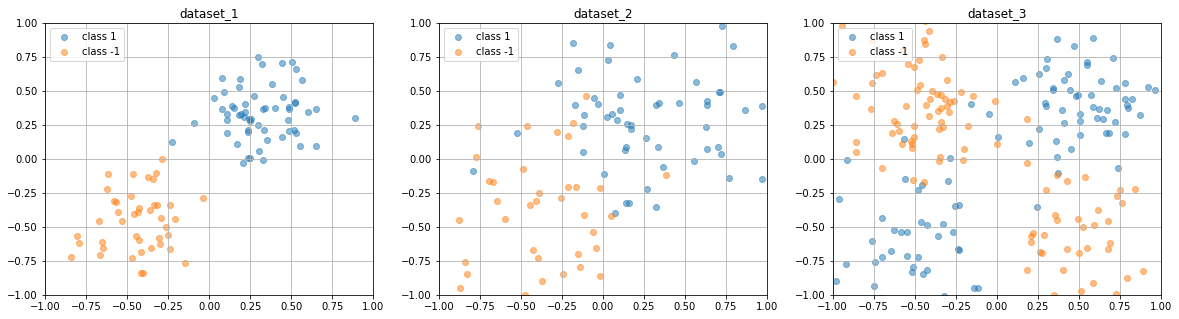

In [2]:
file = open('datasets/classification_datasets', 'rb')
datasets = pkl.load(file)
file.close()
fig, ax = plt.subplots(1,3, figsize=(20, 5))
for i, (name, dataset) in enumerate(datasets.items()):
    
    plotClassification(dataset['train']['x'], dataset['train']['y'], ax=ax[i])
    ax[i].set_title(name)


## III- Kernel SVC 
### 1- Implementing the Gaussian Kernel
Implement the method 'kernel' of the class RBF below, which takes as input two data matrices $X$ and $Y$ of size $N\times d$ and $M\times d$ and returns a gramm matrix $G$ of shape $N\times M$ whose components are $k(x_i,y_j) = \exp(-\Vert x_i-y_j\Vert^2/(2\sigma^2))$. (The fastest solution does not use any for loop!)

In [3]:
class RBF:
    def __init__(self, sigma=1.):
        self.sigma = sigma  ## the variance of the kernel
    def kernel(self,X,Y):
        ## Input vectors X and Y of shape Nxd and Mxd
        N, d = X.shape 
        M, _ = Y.shape
        X = X.reshape(N,1,d,1)
        Y = Y.reshape(1,M,d,1)
        G = ((X-Y).transpose((0, 1, 3, 2))@(X-Y)).reshape(N,M)
        return np.exp(-G/(2*self.sigma**2))
    
class Linear:
    def __init__(self): 
        self = self
    def kernel(self,X,Y):
        ## Input vectors X and Y of shape Nxd and Mxd
        return X @ Y.T



### 2- Implementing the classifier
Implement the methods 'fit' and 'separating_function' of the class KernelSVC below to learn the Kernel Support Vector Classifier.

In [4]:
class KernelSVC:
    
    def __init__(self, C, kernel, epsilon = 1e-3):
        self.type = 'non-linear'
        self.C = C                               
        self.kernel = kernel        
        self.alpha = None
        self.support = None
        self.epsilon = epsilon
        self.norm_f = None
        self.diag = None
       
    
    def fit(self, X, y):
       #### You might define here any variable needed for the rest of the code
        N = len(y)
        K = self.kernel(X,X)
        y_diag = np.diag(y)
        
        # Lagrange dual problem
        def loss(alpha):
            #'''--------------dual loss ------------------ '''
            return - alpha.sum() + 0.5 * alpha.T @ y_diag @ K @ y_diag @ alpha

        # Partial derivate of Ld on alpha
        def grad_loss(alpha):
            # '''----------------partial derivative of the dual loss wrt alpha-----------------'''
            return - np.ones(N) + y_diag @ K @ y_diag @ alpha


        # Constraints on alpha of the shape :
        # -  d - C*alpha  = 0
        # -  b - A*alpha >= 0

        fun_eq = lambda alpha: (0 - y.T @ alpha).reshape(1,1) # '''----------------function defining the equality constraint------------------'''        
        jac_eq = lambda alpha:  - y #'''----------------jacobian wrt alpha of the  equality constraint------------------'''
    
        fun_ineq = lambda alpha:  self.C*np.vstack((np.ones((N,1)),np.zeros((N,1)))) - (np.vstack((np.eye(N),-np.eye(N)))@alpha).reshape(2*N,1) # '''---------------function defining the ineequality constraint-------------------'''     
        jac_ineq = lambda alpha:   - np.vstack((np.eye(N),-np.eye(N))) # '''---------------jacobian wrt alpha of the  inequality constraint-------------------'''
            
        constraints = ({'type': 'eq',  'fun': fun_eq, 'jac': jac_eq},
                       {'type': 'ineq', 
                        'fun': fun_ineq , 
                        'jac': jac_ineq})
        
        optRes = optimize.minimize(fun=lambda alpha: loss(alpha),
                                   x0=np.ones(N), 
                                   method='SLSQP', 
                                   jac=lambda alpha: grad_loss(alpha), 
                                   constraints=constraints)

        self.alpha = optRes.x 
        ## Assign the required attributes
        
        # Support vectors on the margin
        supportIndices = np.logical_and(self.alpha>self.epsilon, self.alpha<self.C-self.epsilon)
        self.support = X[supportIndices] #'''------------------- A matrix with each row corresponding to a support vector ------------------'''
        
        self.b = (y - y_diag @ self.alpha @ K)[supportIndices].mean() #''' -----------------offset of the classifier------------------ '''
        self.norm_f = np.sqrt(self.alpha.T @ y_diag @ K @ y_diag @ self.alpha) # '''------------------------RKHS norm of the function f ------------------------------'''
        
        # Support vectors & intermediate variable 
        # for computing the separating function
        self.X_sp = X[np.where(self.alpha>self.epsilon)]
        self.diag = np.diag(y[np.where(self.alpha>self.epsilon)])@ self.alpha[np.where(self.alpha>self.epsilon)]

    ### Implementation of the separating function $f$
    def separating_function(self,x):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N
        return self.diag.T @ self.kernel(self.X_sp,x)
    
    
    def predict(self, X):
        """ Predict y values in {-1, 1} """
        d = self.separating_function(X)
        return 2 * (d+self.b > 0) - 1

### 2- Fitting the classifier

Run the code block below to fit the classifier and report its output.

Number of support vectors = 2
Number of support vectors = 3
Number of support vectors = 8


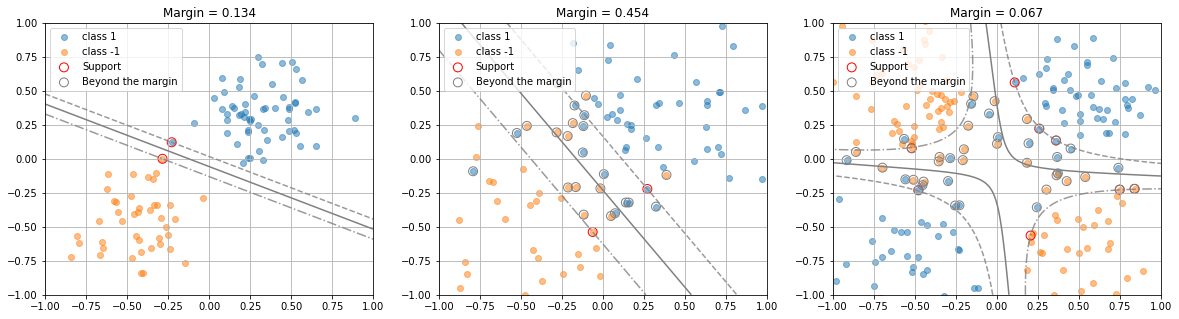

In [5]:
fig, ax = plt.subplots(1,3, figsize=(20, 5))
C = 10000.
kernel = Linear().kernel
model = KernelSVC(C=C, kernel=kernel)
train_dataset = datasets['dataset_1']['train']
model.fit(train_dataset['x'], train_dataset['y'])
plotClassification(train_dataset['x'], train_dataset['y'], model, label='Training', ax = ax[0])

C = 10.
model = KernelSVC(C=C, kernel=kernel)
train_dataset = datasets['dataset_2']['train']
model.fit(train_dataset['x'], train_dataset['y'])
plotClassification(train_dataset['x'], train_dataset['y'], model, label='Training', ax = ax[1])


sigma = 1.5
C=100.
kernel = RBF(sigma).kernel
model = KernelSVC(C=C, kernel=kernel)
train_dataset = datasets['dataset_3']['train']
model.fit(train_dataset['x'], train_dataset['y'])
plotClassification(train_dataset['x'], train_dataset['y'], model, label='Training', ax=ax[2])


# Kernel Regression

## Loading the data

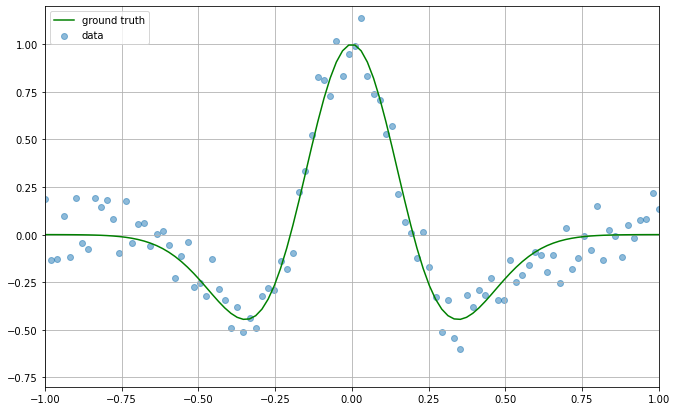

In [6]:
file = open('datasets/regression_datasets', 'rb')
datasets = pkl.load(file)
file.close()
train_set = datasets['dataset_1']['train']
train_set = datasets['dataset_1']['test']
plotRegression(train_set['x'], train_set['y'],Y_clean= train_set['y_clean'])


## Kernel  Support Vector Regression
### 1- Implementing the regressor
Implement the method 'fit' of the classes KernelSVR below to perform Kernel Support Vector Regression. 


In [7]:
class KernelSVR:
    
    def __init__(self, C, kernel, eta= 1e-2, epsilon = 1e-3):
        self.C = C                               
        self.kernel = kernel  
        self.alpha = None # Vector of size 2*N
        self.support = None
        self.eta = eta
        self.epsilon = epsilon
        self.eps = 0.
        self.type='svr'
        
    def fit(self, X, y):
        
        #### You might define here any variable needed for the rest of the code
        N = len(y)
        K = self.kernel(X,X)

        # Vector and matrix used to simplify the computations 
        # (cf. the expressions of the dual and the Lagrangian)
        int_vect = np.concatenate((np.ones(N),-np.ones(N)))
        int_mat = np.hstack((np.eye(N), -np.eye(N)))
            
        # Lagrange dual problem
        def loss(alpha):
            return  -(int_mat @ alpha).T @ y + 0.5*(int_mat @ alpha).T @ K @ (int_mat @ alpha) + self.eta * alpha.sum()
        #'''--------------dual loss ------------------ '''

        # Partial derivate of Ld on alpha
        def grad_loss(alpha):
            return - int_mat.T @ y + int_mat.T @ K @ (int_mat @ alpha) + self.eta
            
        # Constraints on alpha of the shape :
        # -  d - C*alpha  = 0
        # -  b - A*alpha >= 0
        fun_eq = lambda alpha: (0 - int_vect @ alpha).reshape(1,1) # '''----------------function defining the equality constraint------------------'''        
        jac_eq = lambda alpha:  - int_vect   #'''----------------jacobian wrt alpha of the  equality constraint------------------'''
    
        
        fun_ineq = lambda alpha:  self.C*np.vstack((np.ones((2*N,1)),np.zeros((2*N,1)))) - (np.vstack((np.eye(2*N),-np.eye(2*N)))@alpha).reshape(4*N,1) # '''---------------function defining the ineequality constraint-------------------'''     
        jac_ineq = lambda alpha:   - np.vstack((np.eye(2*N),-np.eye(2*N))) # '''---------------jacobian wrt alpha of the  inequality constraint-------------------'''

        
        constraints = ({'type': 'eq',  'fun': fun_eq, 'jac': jac_eq},
                       {'type': 'ineq', 'fun': fun_ineq , 'jac': jac_ineq})
        
        optRes = optimize.minimize(fun=lambda alpha: loss(alpha),
                                   x0= self.C*np.ones(2*N),
                                   method='SLSQP', 
                                   jac=lambda alpha: grad_loss(alpha), 
                                   constraints=constraints, 
                                   tol=1e-7)
        self.alpha = optRes.x
        alpha_pos = self.alpha[0:N]
        alpha_neg = self.alpha[N:2*N]
        diff_alpha = alpha_pos - alpha_neg # int_vect @ alpha
        
        ## Assign the required attributes
        # Support vectors on the margin + or on the margin - 
        vect_pos = np.logical_and(alpha_neg>self.epsilon, alpha_neg<self.C-self.epsilon)
        vect_neg = np.logical_and(alpha_pos>self.epsilon, alpha_pos<self.C-self.epsilon)
        
        supportIndices = np.logical_or(vect_pos, vect_neg)
        self.support = np.vstack((X[supportIndices].squeeze(), y[supportIndices])).T #'''------------------- A matrix with each row corresponding to a support vector ------------------'''
        
        
        margin_pos = (y - diff_alpha @ K - self.eta)[vect_pos].mean()
        margin_neg = (y - diff_alpha @ K + self.eta)[vect_neg].mean()
        self.b = 0.5*(margin_pos + margin_neg)    #''' -----------------offset of the regressor ------------------ '''
        
        # Support vectors & intermediate variable 
        # for computing the separating function 
        X_sp_pos = np.logical_and(alpha_pos>self.epsilon, alpha_pos<np.Inf)
        X_sp_minus = np.logical_and(alpha_neg>self.epsilon, alpha_neg<np.Inf)
        self.X_sp = X[np.logical_or(X_sp_pos, X_sp_minus)]

        self.diag = diff_alpha[np.logical_or(X_sp_pos, X_sp_minus)]

    ### Implementation of the separting function $f$ 
    def regression_function(self,x):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N
        return self.diag @ self.kernel(self.X_sp, x)
    
    def predict(self, X):
        """ Predict y values in {-1, 1} """
        return self.regression_function(X)+self.b

### 2- Fitting the regressor

Run the code block below to fit the regressor and report its output.

Number of support vectors = 18


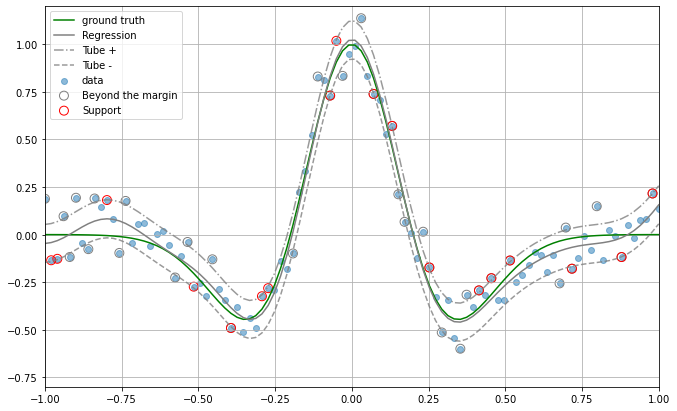

In [8]:
sigma = 0.2
C = 10.
kernel = RBF(sigma).kernel
model = KernelSVR(C,kernel, eta= .1, epsilon = 1e-6)
model.fit(train_set['x'].reshape(-1,1),train_set['y'])
plotRegression(train_set['x'], train_set['y'], Y_clean= train_set['y_clean'], model=model, label='Train')